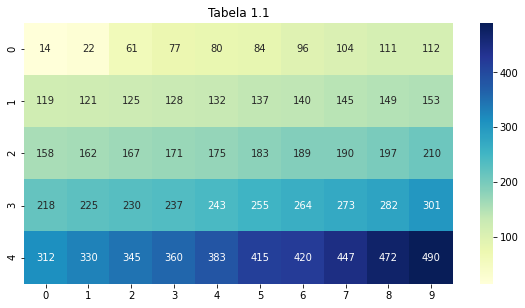

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from tqdm import tqdm
from numba import jit, njit
import os
import time
import matplotlib.ticker as ticker


def parse_file(txt_file,sort=True):
    '''
         Carrega dados de um arquivo txt
    '''
    reslist = []
    if(txt_file.endswith('.csv')):
        with open(txt_file, 'r') as fl:
            for i in fl:
                arr = [float(numb) for numb in i.split(',')]
                reslist = reslist + arr
    reslist = np.array(reslist)
    if(sort): reslist = np.sort(reslist)
    return reslist

# Carrega valores
tabela_11=parse_file("../tabelas/tabela1_1.csv")

# Cria paginas de output
base_output='./imgs/'
output_folders=['n_iter','r','mu','gamma']
for out in output_folders:
    path = os.path.join(base_output,out)
    if(not(os.path.isdir(path))):
       os.makedirs(path)

# Obtem minimos e máximos
min_vals, max_vals = np.amin(tabela_11), np.amax(tabela_11)

# Plota dados em formato de tabela com heatmap
fig = plt.figure(figsize=[6.4*1.5, 4.8])
plt.title("Tabela 1.{}".format(1))
reshaped = np.reshape(tabela_11,(5,-1))
df = pd.DataFrame(reshaped)
ax = sns.heatmap(df,annot=True,cmap="YlGnBu",fmt='g',
            vmin=min_vals,vmax=max_vals)
plt.savefig("./imgs/tabela11.png")


In [2]:
def get_H(t=None,mu=None,sigma=None,gamma=None,log=False):
    '''
    Calcula valor de H(t)
    '''
    #t = np.array(t)
    if(log): t=np.log(t)
    H_res = np.where(t>=mu,np.power((t-mu)/sigma,gamma),0)
    return H_res

def get_sigma(t,t_f,r,gamma,mu):
    '''
    Calcula valor de Sigma
    '''
    eta = 1./len(t)
    sigma = np.power((np.sum(np.power(t-mu,gamma))+
            r*np.power(t_f-mu,gamma))*eta,1/gamma)
    return sigma

def dL_dgamma(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor de dL/dGamma
    '''
    #t = np.array(t)
    H = get_H(t=t,sigma=sigma,mu=mu,gamma=gamma)
    H_f = get_H(t=t_f,mu=mu,sigma=sigma,gamma=gamma)
    inv_l = np.where(t>mu,np.log(sigma/(t-mu)),0)
    inv_l_f = np.log(sigma/(t_f-mu))
    dL= np.sum(1./gamma + (H-1)*inv_l)+r*H_f*inv_l_f
    return dL


def get_next_gamma(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor da proxima iteraçao de gamma
    '''
    #t = np.array(t)
    eta = 1./len(t)
    gamma_next = gamma+eta*dL_dgamma(t,t_f,r,sigma,gamma,mu)
    return gamma_next

def dL_dmu(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor de dL/dMu
    '''
    #t = np.array(t)
    H = get_H(t=t,sigma=sigma,mu=mu,gamma=gamma)
    H_f = get_H(t=t_f,mu=mu,sigma=sigma,gamma=gamma)
    inv_l = np.where(t>mu,gamma/(t-mu),0)
    inv_l_f = gamma/(t_f-mu)
    dL= np.sum((1./gamma + H-1)*inv_l)+r*H_f*inv_l_f
    return dL

def get_next_mu(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor da proxima iteraçao de mu
    '''
    #t = np.array(t)
    eta = 1./len(t)
    mu_next = mu+eta*dL_dmu(t,t_f,r,sigma,gamma,mu)
    return mu_next

def get_parameters(t,t_f,r,sigma_0=None,gamma_0=1.,mu_0=None,n_iter=10, verbose=False, progress=True):
    '''
    Obtem os valores dos parametros
    '''
    t= np.array(t)
    if(mu_0==None): mu_0 = t[0]/2
    if(sigma_0==None): sigma_0 = get_sigma(t,t_f,r,gamma=gamma_0,mu=mu_0)
    
    sig = [sigma_0]
    gam = [gamma_0]
    m = [mu_0]
    if(verbose): print("Iter. 0\n  sigma = {:.3f}\n  gamma = {:.3f}\n  mu = {:.3f}".format(sigma_0,gamma_0,mu_0))
    if(progress): iterat=tqdm(range(n_iter))
    else: iterat = range(n_iter)
    iterat = range(n_iter)
    for i in iterat:
        n_gamma = get_next_gamma(t,t_f,r,sigma=sig[-1],gamma=gam[-1],mu=m[-1])
        n_mu = get_next_mu(t,t_f,r,sigma=sig[-1],gamma=gam[-1],mu=m[-1])
        n_sig =  get_sigma(t,t_f,r,gamma=n_gamma,mu=n_mu)
        sig.append(n_sig)
        gam.append(n_gamma)
        m.append(n_mu)
        if(verbose): print("Iter. {}\n  sigma = {:.3f}\n  gamma = {:.3f}\n  mu = {:.3f}".format(i+1,n_sig,n_gamma,n_mu))
    return sig,gam,m

# Carrega os valores e define parametros
t= tabela_11
t_f=np.max(t)
r=0
n_iterat = 100

%timeit -r 100 get_parameters(t,t_f,r,n_iter=100,verbose=False,progress=False) # realiza teste de performace

6.87 ms ± 210 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [3]:
@jit
def get_H(t=None,mu=None,sigma=None,gamma=None,log=False):
    '''
    Calcula valor de H(t)
    '''
    #t = np.array(t)
    if(log): t=np.log(t)
    H_res = np.where(t>=mu,np.power((t-mu)/sigma,gamma),0)
    return H_res

@jit
def get_sigma(t,t_f,r,gamma,mu):
    '''
    Calcula valor de Sigma
    '''
    eta = 1./len(t)
    sigma = np.power((np.sum(np.power(t-mu,gamma))+
            r*np.power(t_f-mu,gamma))*eta,1/gamma)
    return sigma

@jit
def dL_dgamma(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor de dL/dGamma
    '''
    #t = np.array(t)
    H = get_H(t=t,sigma=sigma,mu=mu,gamma=gamma)
    H_f = get_H(t=t_f,mu=mu,sigma=sigma,gamma=gamma)
    inv_l = np.where(t>mu,np.log(sigma/(t-mu)),0)
    inv_l_f = np.log(sigma/(t_f-mu))
    dL= np.sum(1./gamma + (H-1)*inv_l)+r*H_f*inv_l_f
    return dL


@jit
def get_next_gamma(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor da proxima iteraçao de gamma
    '''
    #t = np.array(t)
    eta = 1./len(t)
    gamma_next = gamma+eta*dL_dgamma(t,t_f,r,sigma,gamma,mu)
    return gamma_next

@jit
def dL_dmu(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor de dL/dMu
    '''
    #t = np.array(t)
    H = get_H(t=t,sigma=sigma,mu=mu,gamma=gamma)
    H_f = get_H(t=t_f,mu=mu,sigma=sigma,gamma=gamma)
    inv_l = np.where(t>mu,gamma/(t-mu),0)
    inv_l_f = gamma/(t_f-mu)
    dL= np.sum((1./gamma + H-1)*inv_l)+r*H_f*inv_l_f
    return dL

@jit
def get_next_mu(t,t_f,r,sigma,gamma,mu):
    '''
    Calcula valor da proxima iteraçao de mu
    '''
    #t = np.array(t)
    eta = 1./len(t)
    mu_next = mu+eta*dL_dmu(t,t_f,r,sigma,gamma,mu)
    return mu_next

def get_parameters(t,t_f,r,sigma_0=None,gamma_0=1.,mu_0=None,n_iter=10, verbose=False, progress=True):
    '''
    Obtem os valores dos parametros
    '''
    t= np.array(t)
    if(mu_0==None): mu_0 = t[0]/2
    if(sigma_0==None): sigma_0 = get_sigma(t,t_f,r,gamma=gamma_0,mu=mu_0)
    
    sig = [sigma_0]
    gam = [gamma_0]
    m = [mu_0]
    if(verbose): print("Iter. 0\n  sigma = {:.3f}\n  gamma = {:.3f}\n  mu = {:.3f}".format(sigma_0,gamma_0,mu_0))
    if(progress): iterat=tqdm(range(n_iter))
    else: iterat = range(n_iter)
    iterat = range(n_iter)
    for i in iterat:
        n_gamma = get_next_gamma(t,t_f,r,sigma=sig[-1],gamma=gam[-1],mu=m[-1])
        n_mu = get_next_mu(t,t_f,r,sigma=sig[-1],gamma=gam[-1],mu=m[-1])
        n_sig =  get_sigma(t,t_f,r,gamma=n_gamma,mu=n_mu)
        sig.append(n_sig)
        gam.append(n_gamma)
        m.append(n_mu)
        if(verbose): print("Iter. {}\n  sigma = {:.3f}\n  gamma = {:.3f}\n  mu = {:.3f}".format(i+1,n_sig,n_gamma,n_mu))
    return sig,gam,m

# Carrega os valores e define parametros
t= tabela_11
t_f=np.max(t)
r=0
n_iterat = 100

get_parameters(t,t_f,r,n_iter=100,verbose=False,progress=False) # executa a funcao para realizar compilacao do jit
%timeit -r 100 get_parameters(t,t_f,r,n_iter=100,verbose=False,progress=False) # realiza teste de performace

890 µs ± 32.6 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)


# Definindo parametros

In [4]:
t= tabela_11
t_f=np.max(t)
r=0
n_iterat = int(1e5)

## Definindo numero de iteracoes para o experimento

Valores finais:
  Sigma = 234.3553081455312
  Gamma = 1.8689701761596813
  Mu    = 0.17686932178030187


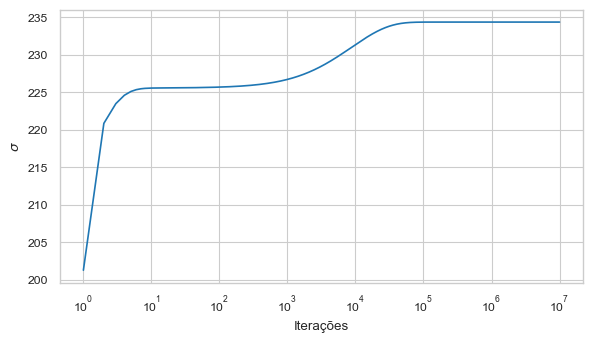

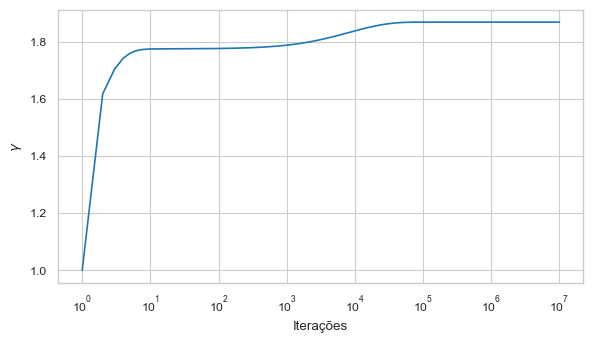

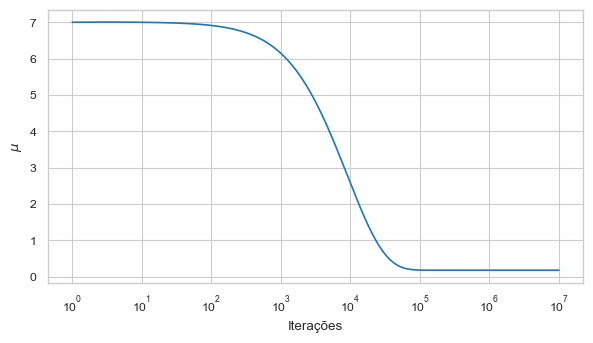

In [10]:
experiment='n_iter'
sns.set_style("whitegrid")
sns.set_context("paper")

fig_1, ax_1 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_2, ax_2 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_3, ax_3 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
ax = [ax_1,ax_2,ax_3]
fig = [fig_1,fig_2,fig_3]
ax_order = ['sigma','gamma','mu']

n_iter_var = int(1e7)

Sigma, Gamma, Mu = get_parameters(t,t_f,r=0,n_iter=n_iter_var,verbose=False,progress=False)
x_values = list(range(1,n_iter_var+2))

ax[0].plot(x_values,Sigma,marker='')
ax[1].plot(x_values,Gamma,marker='')
ax[2].plot(x_values,Mu,marker='')

ax[0].set_ylabel("$\sigma$")
ax[1].set_ylabel("$\gamma$")
ax[2].set_ylabel("$\mu$")
for idx,i in enumerate(ax):
    i.set_xlabel("Iterações")
    #i.legend(loc='upper right',bbox_to_anchor=(1.21, 1.0),)
    i.set(xscale="log",yscale="linear")
    fig[idx].tight_layout(pad=1)
    fig[idx].savefig("./imgs/{}/{}_{}_var.png".format(experiment,ax_order[idx],experiment),dpi=200)

print("Valores finais:\n  Sigma = {}\n  Gamma = {}\n  Mu    = {}".format(Sigma[-1], Gamma[-1], Mu[-1] ))

## Tempo de execução

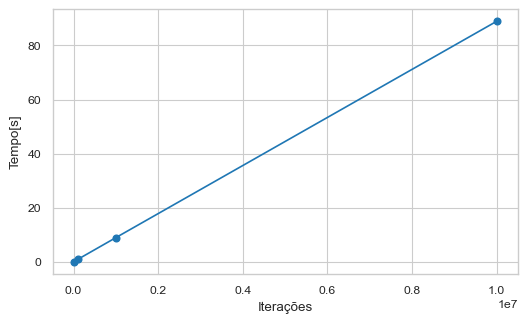

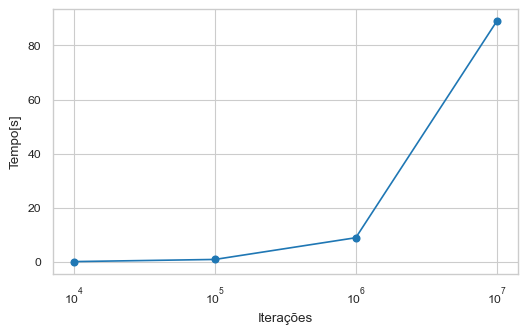

In [6]:

n_iter_var = [int(1e4),int(1e5),int(1e6),int(1e7)]
results = []
for i in n_iter_var[:]:
    start = time.time()
    _, _, _ = get_parameters(t,t_f,r=0,n_iter=i,verbose=False,progress=False)
    end = time.time()
    delta = end-start
    results.append(delta)

fig, ax = plt.subplots(1,1,dpi=100,figsize=(6,3.5))

sns.set_style("whitegrid")
sns.set_context("paper")

ax.plot(n_iter_var[:],results,marker='o')
#fig.tight_layout(pad=1)
ax.set_ylabel("Tempo[s]")
ax.set_xlabel("Iterações")
fig.savefig('./imgs/time_comparison.png',dpi=200)

fig_2, ax_2 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))

sns.set_style("whitegrid")
sns.set_context("paper")

ax_2.plot(n_iter_var[:],results,marker='o')
ax_2.set(xscale="log",yscale="linear")
#fig.tight_layout(pad=1)
ax_2.set_ylabel("Tempo[s]")
ax_2.set_xlabel("Iterações")
fig_2.savefig('./imgs/time_comparison_log.png',dpi=200)

## Variando r

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.59s/it]


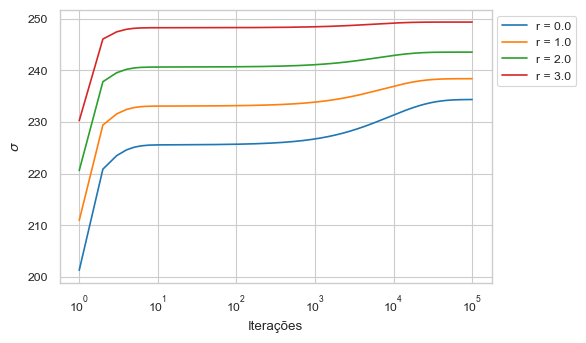

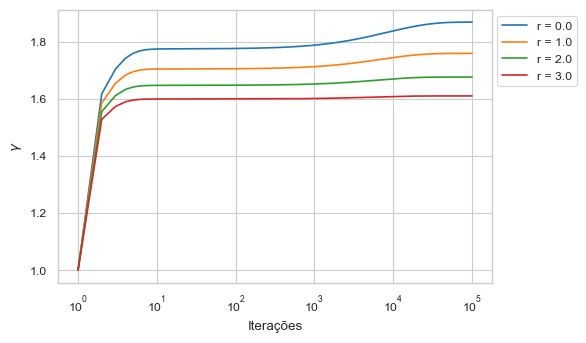

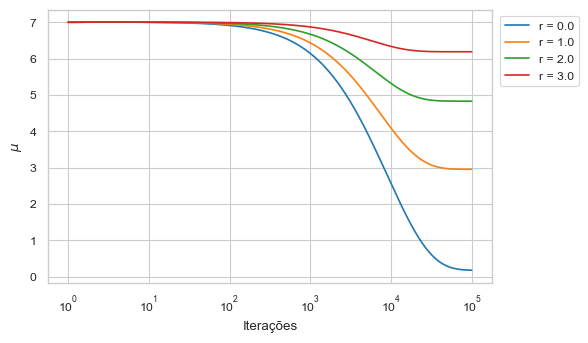

In [7]:
experiment='r'
fig_1, ax_1 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_2, ax_2 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_3, ax_3 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
ax = [ax_1,ax_2,ax_3]
fig = [fig_1,fig_2,fig_3]
ax_order = ['sigma','gamma','mu']

sns.set_style("whitegrid")
sns.set_context("paper")

for r_var in tqdm([0.,1.,2.,3.]):
    Sigma, Gamma, Mu = get_parameters(t,t_f,r_var,n_iter=n_iterat,verbose=False,progress=False)
    x_values = list(range(1,n_iterat+2))
    
    ax[0].plot(x_values,Sigma,label='r = {}'.format(r_var),marker='')
    ax[1].plot(x_values,Gamma,label='r = {}'.format(r_var),marker='')
    ax[2].plot(x_values,Mu,label='r = {}'.format(r_var),marker='')

ax[0].set_ylabel("$\sigma$")
ax[1].set_ylabel("$\gamma$")
ax[2].set_ylabel("$\mu$")
for idx,i in enumerate(ax):
    i.set_xlabel("Iterações")
    i.legend(loc='upper right',bbox_to_anchor=(1.21, 1.0),)
    i.set(xscale="log",yscale="linear")
    fig[idx].tight_layout(pad=1)
    fig[idx].savefig("./imgs/{}/{}_{}_var.png".format(experiment,ax_order[idx],experiment),dpi=200)


## Variando $\mu$

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


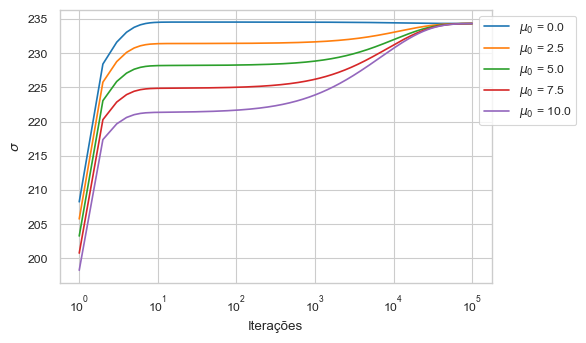

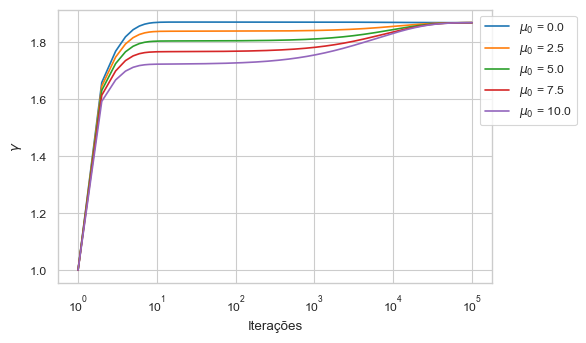

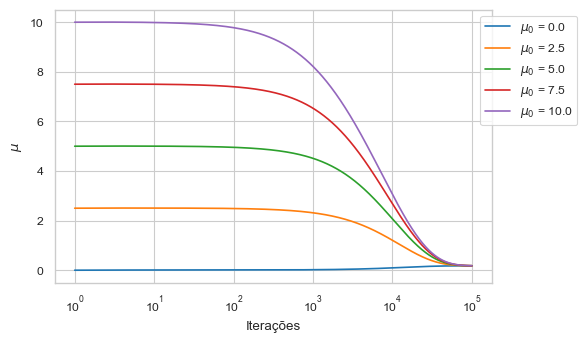

In [8]:
experiment='mu'
fig_1, ax_1 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_2, ax_2 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_3, ax_3 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
ax = [ax_1,ax_2,ax_3]
fig = [fig_1,fig_2,fig_3]
ax_order = ['sigma','gamma','mu']
#fig.subplots_adjust(hspace=0.4)
sns.set_style("whitegrid")
sns.set_context("paper")

for mu_var in tqdm(np.linspace(0,10,5)):
    Sigma, Gamma, Mu = get_parameters(t,t_f,r,mu_0=mu_var,n_iter=n_iterat,verbose=False,progress=False)
    x_values = list(range(1,n_iterat+2))
    
    ax[0].plot(x_values,Sigma,label='$\mu_0$ ='+' {}'.format(mu_var),marker='')
    ax[1].plot(x_values,Gamma,label='$\mu_0$ ='+' {}'.format(mu_var),marker='')
    ax[2].plot(x_values,Mu,label='$\mu_0$ ='+' {}'.format(mu_var),marker='')

ax[0].set_ylabel("$\sigma$")
ax[1].set_ylabel("$\gamma$")
ax[2].set_ylabel("$\mu$")
for idx,i in enumerate(ax):
    i.set_xlabel("Iterações")
    i.legend(loc='upper right',bbox_to_anchor=(1.21, 1.0),)
    i.set(xscale="log",yscale="linear")
    fig[idx].tight_layout(pad=1)
    fig[idx].savefig("./imgs/{}/{}_{}_var.png".format(experiment,ax_order[idx],experiment),dpi=200)


## Variando $\gamma$

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


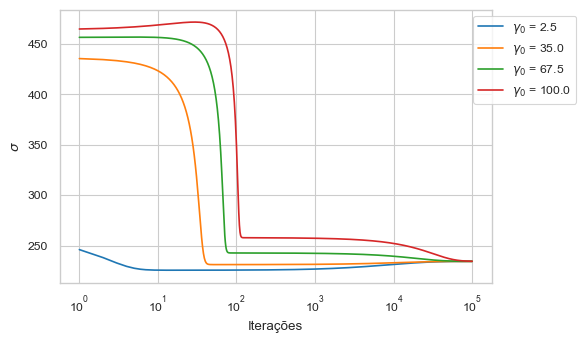

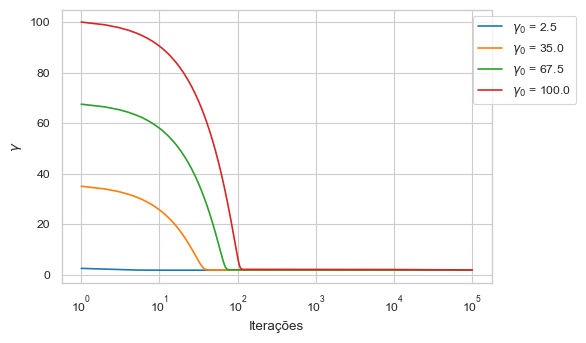

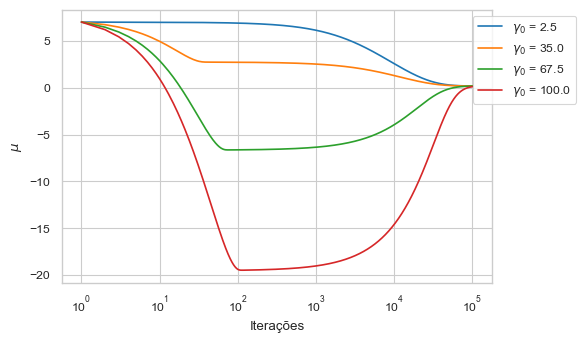

In [9]:
experiment='gamma'
fig_1, ax_1 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_2, ax_2 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
fig_3, ax_3 = plt.subplots(1,1,dpi=100,figsize=(6,3.5))
ax = [ax_1,ax_2,ax_3]
fig = [fig_1,fig_2,fig_3]
ax_order = ['sigma','gamma','mu']
#fig.subplots_adjust(hspace=0.4)
sns.set_style("whitegrid")
sns.set_context("paper")

for gamma_var in tqdm(np.linspace(2.5,100,4)):
    Sigma, Gamma, Mu = get_parameters(t,t_f,r,gamma_0=gamma_var,n_iter=n_iterat,verbose=False,progress=False)
    x_values = list(range(1,n_iterat+2))
    
    ax[0].plot(x_values,Sigma,label='$\gamma_0$ ='+' {}'.format(gamma_var),marker='')
    ax[1].plot(x_values,Gamma,label='$\gamma_0$ ='+' {}'.format(gamma_var),marker='')
    ax[2].plot(x_values,Mu,label='$\gamma_0$ ='+' {}'.format(gamma_var),marker='')

ax[0].set_ylabel("$\sigma$")
ax[1].set_ylabel("$\gamma$")
ax[2].set_ylabel("$\mu$")
for idx,i in enumerate(ax):
    i.set_xlabel("Iterações")
    i.legend(loc='upper right',bbox_to_anchor=(1.21, 1.0),)
    i.set(xscale="log",yscale="linear")
    fig[idx].tight_layout(pad=1)
    fig[idx].savefig("./imgs/{}/{}_{}_var.png".format(experiment,ax_order[idx],experiment),dpi=200)
